<h1 align="center"> Geometric Methods in ML - ENSAE 2016/2017 </h1>
<h2 align="center"> Kernels approximation with Random Features </h2>
<h4 align="right"> <i>Author: Hicham Janati </i></h4>

<hr> 

This notebook uses the RFF class implemented in <a href="RFF-I.ipynb"> RFF - Notebook I </a> to perform Kernel approximations on real data.


In [10]:
import numpy as np # Thinly−wrapped numpy
import pandas as pd
from matplotlib import cm 
import matplotlib as mpl
%matplotlib inline 
from matplotlib import pyplot as plt 
data = '../data/'

Import the RFF object:

In [11]:
from RFF import*

# Experiments I
In the following section, using USPS and Gisette datasets we:
- Evaluate RF approximation quality:
    1. MSE(Approximated Kernel, True Kernel)
    2. Computation time
    
- Effect of number of samples / dimension

#### Load data

In [12]:
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import ShuffleSplit,  GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

digits = fetch_mldata("USPS")
X_usps, y_usps = digits.data, digits.target.astype(np.int) - 1

X_gis = pd.read_csv(data + "gisette/X_train.txt",sep=' ',header=None).drop([5000],axis=1).values
y_gis = pd.read_csv(data + "gisette/y_train.txt",header=None).values

print("USPS: X.shape = {} | y.shape = {} | number of classes : {}".format(X_usps.shape, y_usps.shape, len(np.unique(y_usps))))
print("Gisette: X.shape = {} | y.shape = {} | number of classes : {}".format(X_gis.shape, y_gis.shape, len(np.unique(y_gis))))


USPS: X.shape = (9298, 256) | y.shape = (9298,) | number of classes : 10
Gisette: X.shape = (6000, 5000) | y.shape = (6000, 1) | number of classes : 2


## Kernel approximation MSE
Let's compute the MSE betwen the exact kernel matrix and the approximated one. The USPS dataset has a lot of samples, where as Gisette is high dimensional. We study the effect of N and d on Gisette and USPS respectively.

#### Gisette Dataset:
##### Effect of the dimension of the data d
Since we're interested in changing d, we keep a low number of data samples (100):

In [17]:
from sklearn.metrics.pairwise import rbf_kernel, laplacian_kernel
from time import time

indx = [2**i for i in range(1)]
n_repeats = 1
X = X_gis.copy()
gamma = 2.5
n_samples = 100
ds = [50,500,1000,3000,5000]
empty = np.zeros((len(ds),len(indx),n_repeats)) 
time_laplace_true, time_rbf_true = np.zeros(len(ds)), np.zeros(len(ds))
time_rbf_approx, errors_laplace, time_laplace_approx, errors_rbf = empty.copy(), empty.copy(), empty.copy(), empty.copy()


for i,d_ in enumerate(ds):
    X = X_gis[:n_samples,:d_]
    
    t = time()
    K_true_rbf = rbf_kernel(X,gamma=gamma)
    time_rbf_true[i] = time()-t
    
    t = time()
    K_true_laplace = laplacian_kernel(X,gamma=gamma)
    time_laplace_true[i] = time()-t
    
    for k,D in enumerate(indx):
        for j in range(n_repeats):
            GAUSS = RFF(gamma=gamma, D=D, metric="rbf")
            t = time()
            GAUSS.fit(X)
            K_rbf = GAUSS.compute_kernel(X)
            time_rbf_approx[i,k,j] = time()-t

            LAPLACE = RFF(gamma=gamma, D=D, metric="laplace")
            t = time()
            LAPLACE.fit(X)
            K_laplace = LAPLACE.compute_kernel(X)
            time_laplace_approx[i,k,j] = time()-t

            errors_rbf[i,k,j] = ((K_rbf-K_true_rbf)**2).mean()
            errors_laplace[i,k,j] = ((K_laplace-K_true_laplace)**2).mean()


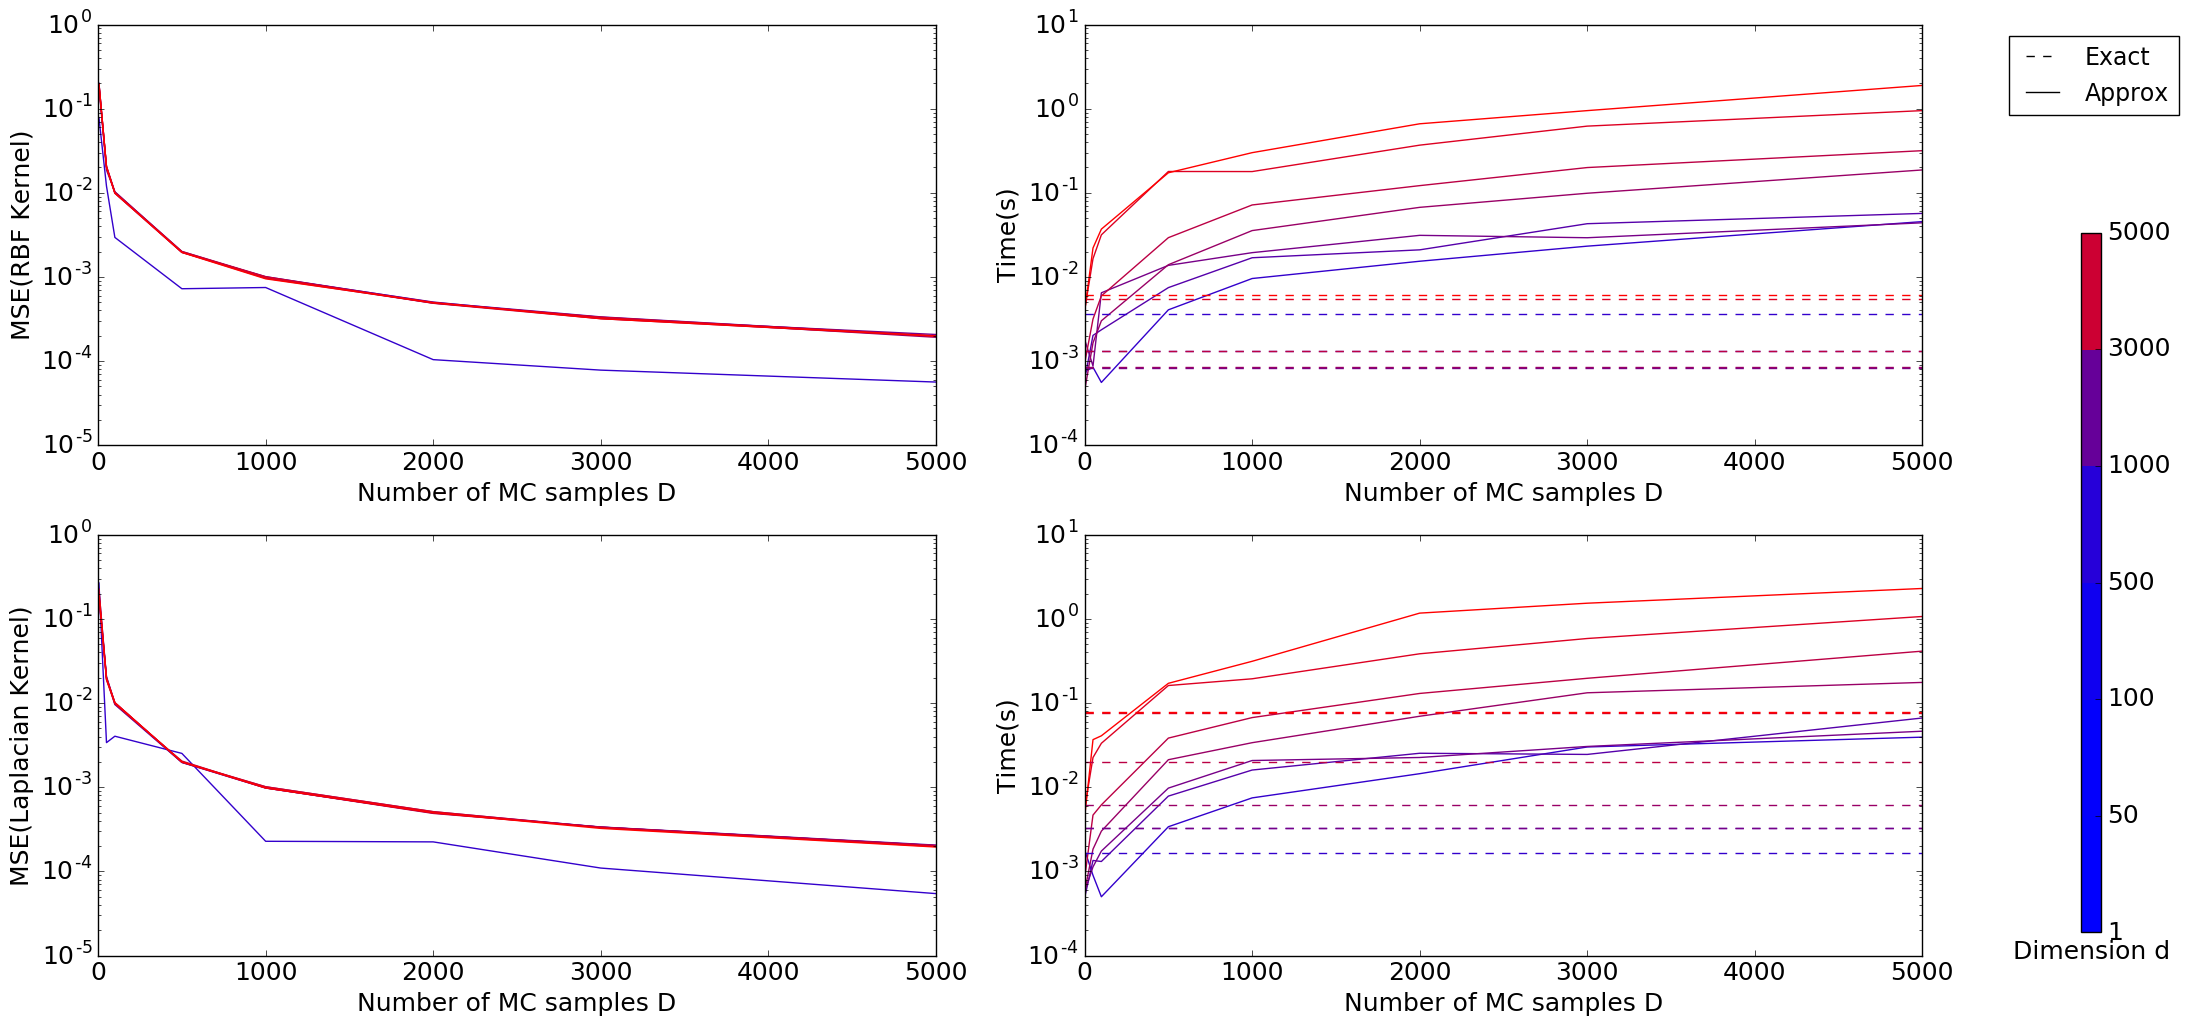

In [12]:
import matplotlib.lines as mlines

dash_patch = mlines.Line2D([],[],color="k",linestyle='--', label='Exact')
ctn_patch = mlines.Line2D([],[],color="k",  label='Approx')

mpl.rcParams.update({'font.size': 18})
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
colormap = mpl.colors.LinearSegmentedColormap.from_list('mycolors',['blue','red'])
colors = [colormap(i) for i in np.linspace(0.2, 1, len(ds))]
Z = [[0,0],[0,0]]
CS3 = plt.contourf(Z, ds, cmap=colormap)
plt.clf()
plt.subplot(221)
plt.gca().set_prop_cycle('color',colors)
plt.plot(indx, errors_rbf.mean(axis=-1).T,linewidth=1)
plt.ylabel("MSE(RBF Kernel)")
plt.xlabel("Number of MC samples D")
plt.yscale("log")

plt.subplot(222)
plt.gca().set_prop_cycle('color',colors)
plt.plot(indx, time_rbf_approx.mean(axis=-1).T,linewidth=1)
plt.plot(indx, np.repeat(time_rbf_true[np.newaxis,:], len(indx), axis=0), '--')
plt.yscale("log")
plt.ylabel("Time(s)")
plt.xlabel("Number of MC samples D")
plt.legend(handles=[dash_patch, ctn_patch], bbox_to_anchor=[1.32,1], handlelength=2, fontsize=17)
plt.tight_layout()


plt.subplot(223)
plt.gca().set_prop_cycle('color',colors)
plt.plot(indx, errors_laplace.mean(axis=-1).T,linewidth=1)
plt.ylabel("MSE(Laplacian Kernel)")
plt.xlabel("Number of MC samples D")
plt.yscale("log")

plt.subplot(224)
plt.gca().set_prop_cycle('color',colors)
plt.plot(indx, time_laplace_approx.mean(axis=-1).T,linewidth=1)
plt.plot(indx, np.repeat(time_laplace_true[np.newaxis,:], len(indx), axis=0), '--')
plt.yscale("log")
plt.ylabel("Time(s)")
plt.xlabel("Number of MC samples D")
cbaxes = fig.add_axes([1.05, 0.05, 0.01, 0.7]) 
cbaxes.set_xlabel("Dimension d")
cb = plt.colorbar(CS3, cax = cbaxes)  
plt.show()

The approximation is clearly better for low dimensions but at the expense of stability (the variance is higher). The effect of the dimension of the data on the computation time is minimal: using the exact kernel is faster. The Laplacian kernel seems to benefit more from the RF approx than the gaussian kernel because the exact kernel function is slower.

#### USPS Dataset
##### Effect of the number of data samples n

To study the effect of data samples number, we clip the dimension of the data to 50. 

In [13]:
from sklearn.metrics.pairwise import rbf_kernel, laplacian_kernel
from time import time

n_repeats = 1
X = X_usps.copy()
gamma = 2.5
n_samples = 100
ds = [1,50,100,500,1000,3000,5000]
empty = np.zeros((len(ds),len(indx),n_repeats)) 
time_laplace_true, time_rbf_true = np.zeros(len(ds)), np.zeros(len(ds))
time_rbf_approx, errors_laplace, time_laplace_approx, errors_rbf = empty.copy(), empty.copy(), empty.copy(), empty.copy()

indx = [5,50,100,500,1000,2000,3000,5000]

for i,d_ in enumerate(ds):
    X = X_gis[:n_samples,:d_]
    
    t = time()
    K_true_rbf = rbf_kernel(X,gamma=gamma)
    time_rbf_true[i] = time()-t
    
    t = time()
    K_true_laplace = laplacian_kernel(X,gamma=gamma)
    time_laplace_true[i] = time()-t
    
    for k,D in enumerate(indx):
        for j in range(n_repeats):
            GAUSS = RFF(gamma=gamma, D=D, metric="rbf")
            t = time()
            GAUSS.fit(X)
            K_rbf = GAUSS.compute_kernel(X)
            time_rbf_approx[i,k,j] = time()-t

            LAPLACE = RFF(gamma=gamma, D=D, metric="laplace")
            t = time()
            LAPLACE.fit(X)
            K_laplace = LAPLACE.compute_kernel(X)
            time_laplace_approx[i,k,j] = time()-t

            errors_rbf[i,k,j] = ((K_rbf-K_true_rbf)**2).mean()
            errors_laplace[i,k,j] = ((K_laplace-K_true_laplace)**2).mean()


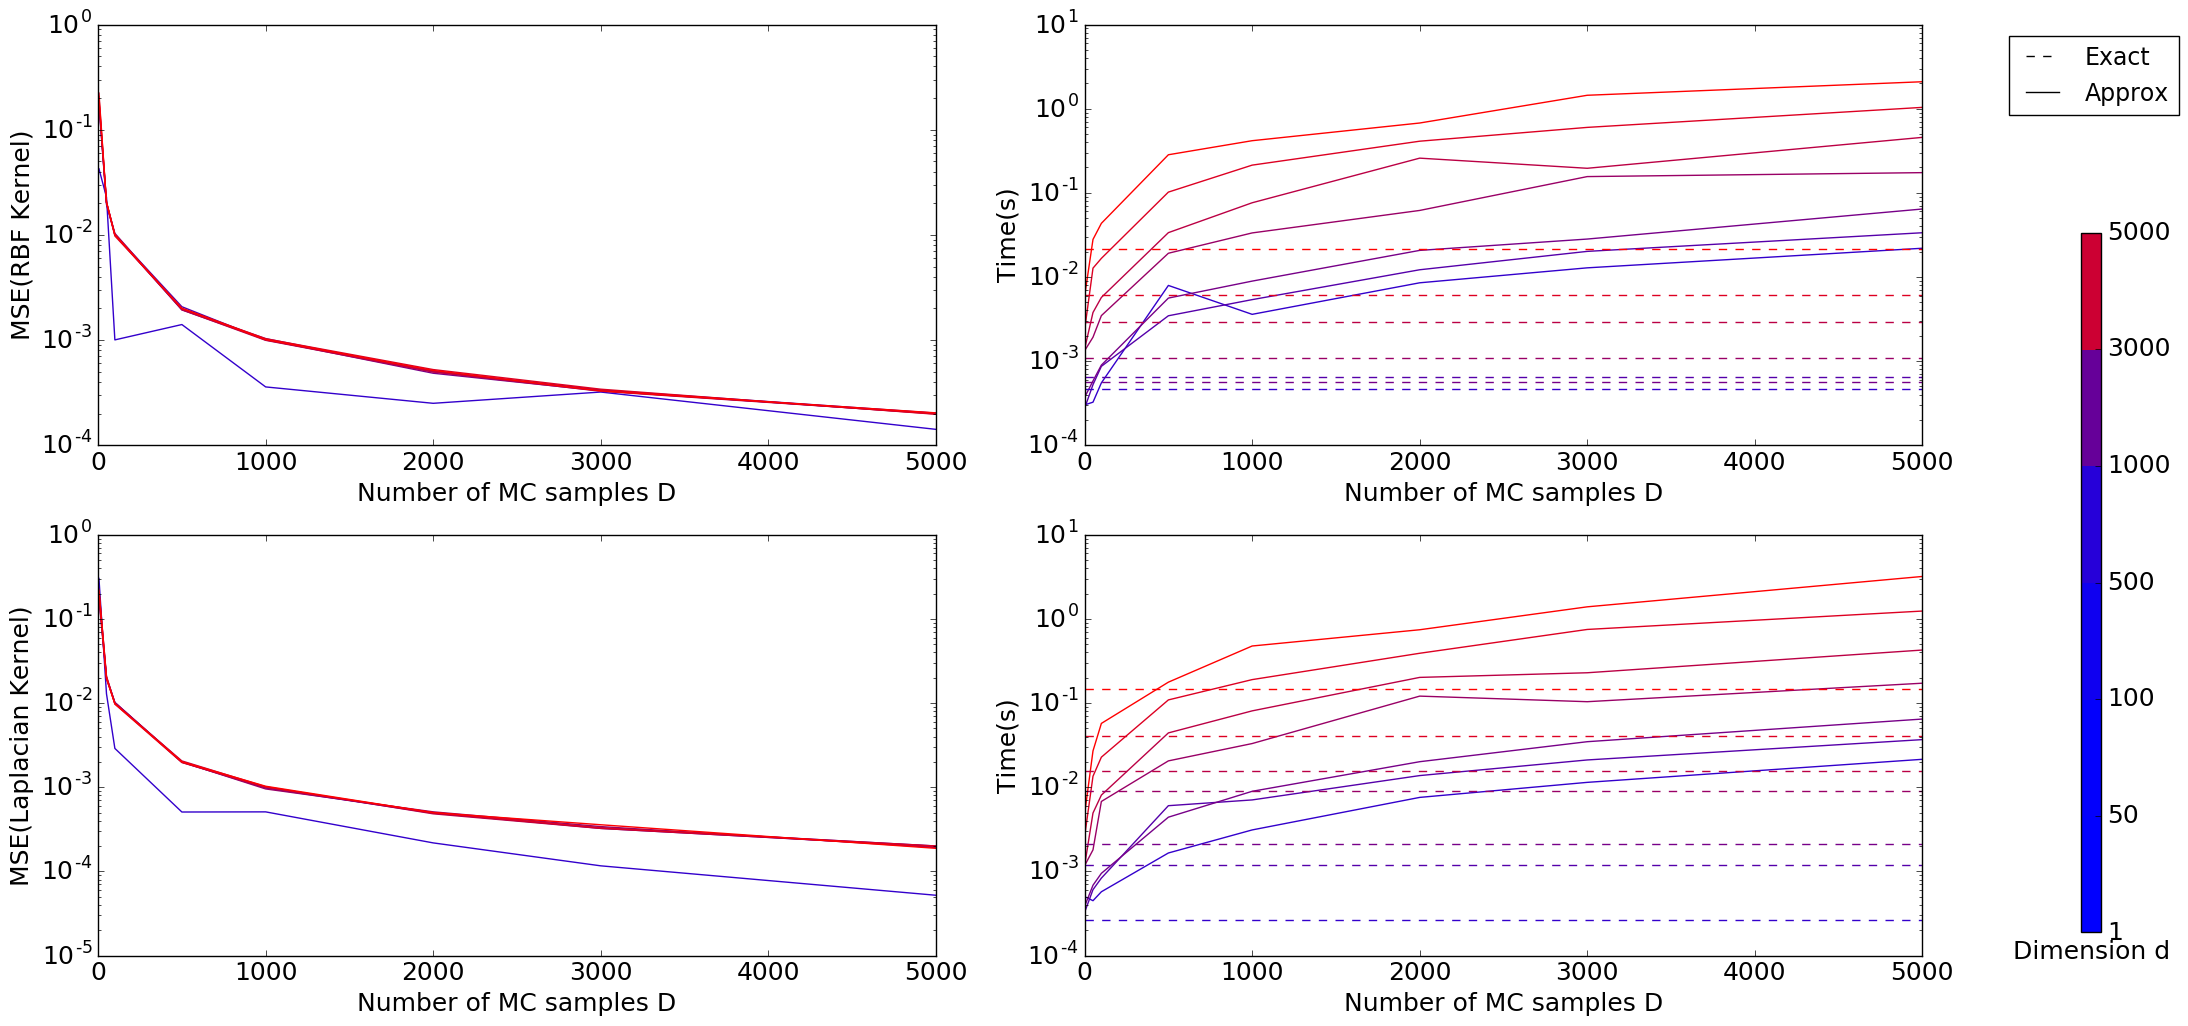

In [14]:
import matplotlib.lines as mlines

dash_patch = mlines.Line2D([],[],color="k",linestyle='--', label='Exact')
ctn_patch = mlines.Line2D([],[],color="k",  label='Approx')

mpl.rcParams.update({'font.size': 18})
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
colormap = mpl.colors.LinearSegmentedColormap.from_list('mycolors',['blue','red'])
colors = [colormap(i) for i in np.linspace(0.2, 1, len(ds))]
Z = [[0,0],[0,0]]
CS3 = plt.contourf(Z, ds, cmap=colormap)
plt.clf()
plt.subplot(221)
plt.gca().set_prop_cycle('color',colors)
plt.plot(indx, errors_rbf.mean(axis=-1).T,linewidth=1)
plt.ylabel("MSE(RBF Kernel)")
plt.xlabel("Number of MC samples D")
plt.yscale("log")

plt.subplot(222)
plt.gca().set_prop_cycle('color',colors)
plt.plot(indx, time_rbf_approx.mean(axis=-1).T,linewidth=1)
plt.plot(indx, np.repeat(time_rbf_true[np.newaxis,:], len(indx), axis=0), '--')
plt.yscale("log")
plt.ylabel("Time(s)")
plt.xlabel("Number of MC samples D")
plt.legend(handles=[dash_patch, ctn_patch], bbox_to_anchor=[1.32,1], handlelength=2, fontsize=17)
plt.tight_layout()


plt.subplot(223)
plt.gca().set_prop_cycle('color',colors)
plt.plot(indx, errors_laplace.mean(axis=-1).T,linewidth=1)
plt.ylabel("MSE(Laplacian Kernel)")
plt.xlabel("Number of MC samples D")
plt.yscale("log")

plt.subplot(224)
plt.gca().set_prop_cycle('color',colors)
plt.plot(indx, time_laplace_approx.mean(axis=-1).T,linewidth=1)
plt.plot(indx, np.repeat(time_laplace_true[np.newaxis,:], len(indx), axis=0), '--')
plt.yscale("log")
plt.ylabel("Time(s)")
plt.xlabel("Number of MC samples D")
cbaxes = fig.add_axes([1.05, 0.05, 0.01, 0.7]) 
cbaxes.set_xlabel("Dimension d")
cb = plt.colorbar(CS3, cax = cbaxes)  
plt.show()

The number of samples n has no effect on the accuracy of the approximation (as expected since the sampling distribution is independant of n). With large amount of data, the approximated kernel can be faster for some values of D: a tradeoff (Approximation quality, computation time) must be made to choose D.

# In the Next Notebook: 
- SVM Classification on real data (Gisette, USPS) (Gaussian/Laplacian Kernel)

 <a href="RFF-III.ipynb"> Go to the next notebook </a>